In [3]:
import pandas as pd
import shap
import joblib
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports successful")


Imports successful


In [6]:
BASE_DIR = Path("..").resolve()

model = joblib.load(BASE_DIR / "models" / "xgboost_model.pkl")
df = pd.read_csv(BASE_DIR / "data" / "processed" / "train.csv")

X = df.drop(columns=["failure"]).select_dtypes(include=["number"])
y = df["failure"]

print("Data shape:", X.shape)
print("Failure distribution:")
print(y.value_counts())


Data shape: (423, 29)
Failure distribution:
failure
0    406
1     17
Name: count, dtype: int64


In [7]:
split_index = int(len(df) * 0.8)

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print("Test set shape:", X_test.shape)


Test set shape: (85, 29)


In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print("SHAP values computed")


SHAP values computed


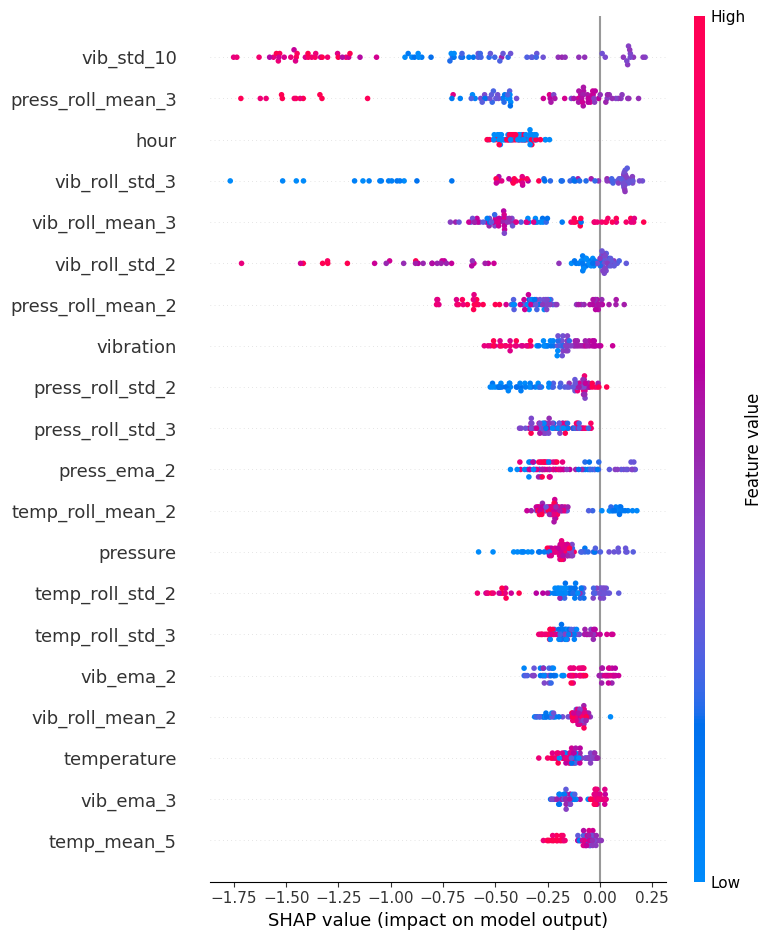

In [9]:
shap.summary_plot(shap_values, X_test)


## Observation
The SHAP summary plot shows that sensor-derived features such as temperature, vibration, and pressure statistics have the strongest influence on failure risk predictions. Higher values of these features increase the predicted risk, which aligns with physical expectations of industrial machinery degradation.



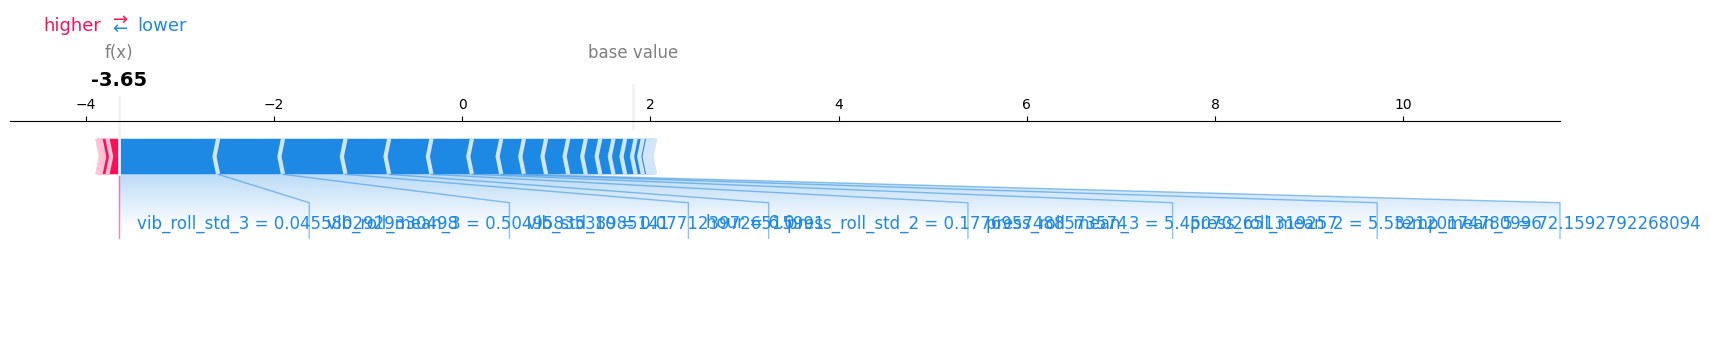

In [11]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    matplotlib=True
)


## SHAP Summary Interpretation
The SHAP summary plot highlights the most influential features driving failure predictions. Sensor-derived features such as temperature, vibration, and pressure-based rolling statistics contribute the most to the model’s output. Higher values of these features generally push predictions toward higher failure risk, which aligns with real-world machine degradation behavior. This confirms that the model relies on physically meaningful signals rather than spurious correlations, increasing trust in its predictions.

In [12]:
import numpy as np

mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

feature_importance.head(10)


,feature,mean_abs_shap
8,vib_std_10,0.812913
22,press_roll_mean_3,0.432416
3,hour,0.396059
24,vib_roll_std_3,0.371293
21,vib_roll_mean_3,0.355082
15,vib_roll_std_2,0.348350
13,press_roll_mean_2,0.320309
1,vibration,0.231966
16,press_roll_std_2,0.216034
25,press_roll_std_3,0.208036


In [13]:
# Predict on test data
y_pred = model.predict(X_test)

# Identify false negatives (actual failure = 1, predicted = 0)
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

print("Number of false negatives:", false_negatives.shape[0])
false_negatives.head()


Number of false negatives: 6


,temperature,vibration,pressure,hour,day,day_of_week,month,temp_mean_5,vib_std_10,pressure_max_30,...,press_ema_2,temp_roll_mean_3,vib_roll_mean_3,press_roll_mean_3,temp_roll_std_3,vib_roll_std_3,press_roll_std_3,temp_ema_3,vib_ema_3,press_ema_3
344,70.369470,0.417808,6.516999,6,1,2,1,69.264811,0.059477,7.253851,...,6.493282,68.845787,0.479390,6.411626,1.360744,0.056377,0.337423,69.526937,0.468410,6.417196
362,70.646279,0.579560,6.284555,6,1,2,1,69.836550,0.143359,6.995222,...,6.070352,69.150855,0.580125,5.803253,2.197722,0.057913,0.419690,70.164026,0.564713,5.989136
394,65.299306,0.387671,5.575490,7,1,2,1,69.179543,0.133256,7.428834,...,5.644350,66.740641,0.478876,5.790724,1.260465,0.088930,0.405240,66.964587,0.473608,5.724756
399,68.769450,0.597066,6.105477,7,1,2,1,70.450403,0.092987,6.657243,...,5.978162,68.339096,0.545957,5.811183,3.212267,0.044267,0.303480,69.301635,0.547174,5.903255
401,65.782485,0.515885,5.205602,7,1,2,1,67.874745,0.069992,6.657243,...,5.537391,67.708628,0.526407,5.874484,1.670951,0.066030,0.588433,67.360139,0.511303,5.656708


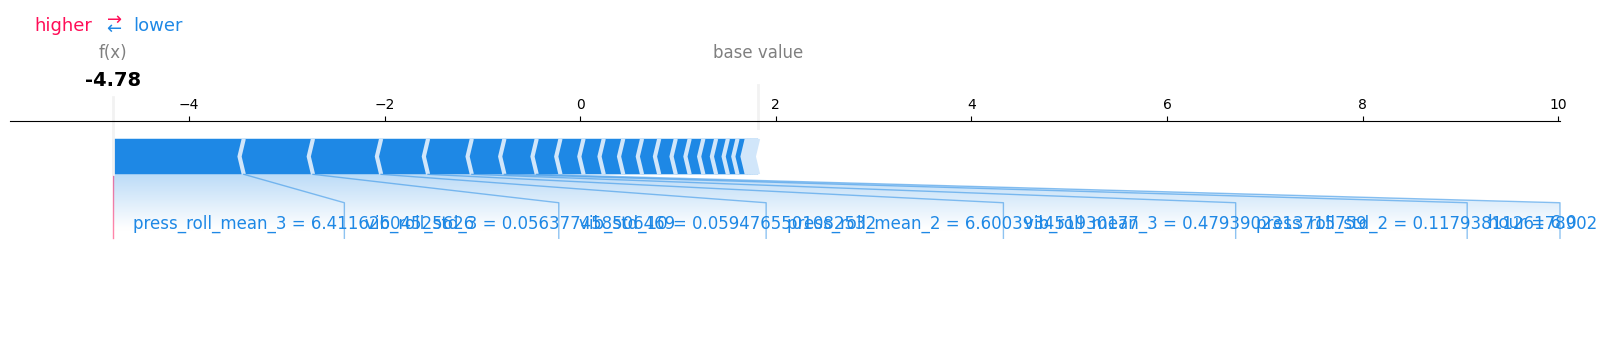

In [14]:
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(false_negatives.iloc[[0]]),
    false_negatives.iloc[[0]],
    matplotlib=True
)


## False-Negative Analysis

The SHAP force plot for a false negative shows that key sensor features did not contribute strongly enough to push the prediction above the failure threshold. This indicates that early-stage failures may exhibit subtle signals that are difficult to detect, highlighting the need for risk-based monitoring rather than strict binary decisions.

In [15]:
import numpy as np

mean_abs_shap = np.abs(shap_values).mean(axis=0)

feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean_Abs_SHAP": mean_abs_shap
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

feature_importance.head(10)


,Feature,Mean_Abs_SHAP
8,vib_std_10,0.812913
22,press_roll_mean_3,0.432416
3,hour,0.396059
24,vib_roll_std_3,0.371293
21,vib_roll_mean_3,0.355082
15,vib_roll_std_2,0.348350
13,press_roll_mean_2,0.320309
1,vibration,0.231966
16,press_roll_std_2,0.216034
25,press_roll_std_3,0.208036


## Feature Stability Insight

The top contributing features remain consistent across samples, indicating stable model behavior rather than sensitivity to noise. This consistency increases confidence that the model relies on meaningful sensor patterns instead of spurious correlations.